# CLIP feature + Logistic Regression for CIFAR10 data sets

Install the followings (See [CLIP code](https://github.com/openai/CLIP) for details.)

```
$ conda install --yes -c pytorch pytorch torchvision cudatoolkit=11.8
$ pip install ftfy regex tqdm
$ pip install git+https://github.com/openai/CLIP.git
```


In [1]:
import os
import clip
import torch

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from tqdm import tqdm

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Load the dataset
root = os.path.expanduser("~/.cache")
train = CIFAR10(root, download=True, train=True, transform=preprocess)
test = CIFAR10(root, download=True, train=False, transform=preprocess)


def get_features(dataset):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=100)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

Files already downloaded and verified
Files already downloaded and verified


In [2]:
# Calculate the image features
train_features, train_labels = get_features(train)
test_features, test_labels = get_features(test)

  0%|                                                                            | 0/500 [00:00<?, ?it/s]/home/kurita/anaconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.75it/s]


In [3]:

print(train_features.shape)

pca = PCA(n_components=2)
pca_scores = pca.fit_transform(train_features)

#print(pca_scores)


(50000, 512)


<Axes: xlabel='Principal Component 1', ylabel='Principal Component 2'>

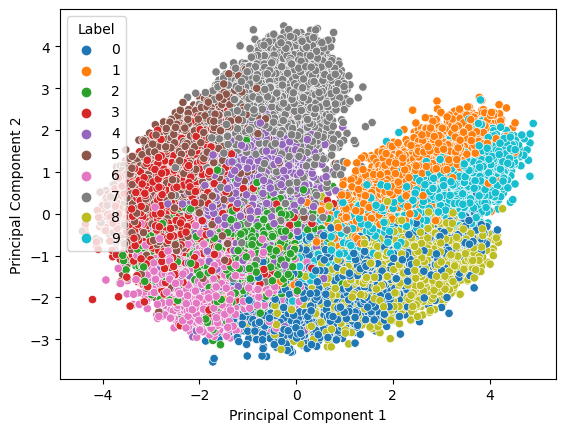

In [4]:

#plt.scatter(pca_scores[:, 0], pca_scores[:, 1])
#plt.show()

#convert principal components
pca_Df = pd.DataFrame(data = pca_scores,
                                  columns = ['Principal Component 1', 'Principal Component 2'])
pca_Df['Label'] = train_labels
pca_Df.head()

#plotting dataset into 2d graph
#plt.figure(figsize = (10,7))
sns.scatterplot(
    x = "Principal Component 1", y = "Principal Component 2",
    hue = "Label",
    palette = sns.color_palette("tab10", 10),
    data = pca_Df,
    legend = "full",
    alpha = 1.0
)

In [5]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random')
tsne_scores = tsne.fit_transform(train_features)



<Axes: xlabel='t-SNE Component 1', ylabel='t-SNE Component 2'>

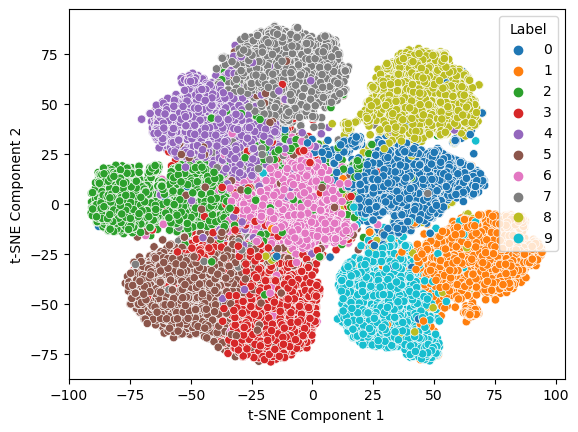

In [6]:
#plt.scatter(tsne_scores[:, 0], tsne_scores[:, 1])
#plt.show()

#convert principal components
tsne_Df = pd.DataFrame(data = tsne_scores,
                                  columns = ['t-SNE Component 1', 't-SNE Component 2'])
tsne_Df['Label'] = train_labels
tsne_Df.head()

#plotting dataset into 2d graph
#plt.figure(figsize = (10,7))
sns.scatterplot(
    x = "t-SNE Component 1", y = "t-SNE Component 2",
    hue = "Label",
    palette = sns.color_palette("tab10", 10),
    data = tsne_Df,
    legend = "full",
    alpha = 1.0
)


In [7]:
# Perform logistic regression
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
classifier.fit(train_features, train_labels)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         5130     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15129D+05    |proj g|=  5.93331D+03

At iterate   50    f=  7.22581D+03    |proj g|=  1.37119D+03

At iterate  100    f=  6.30837D+03    |proj g|=  1.77703D+02

At iterate  150    f=  6.11858D+03    |proj g|=  5.95964D+01

At iterate  200    f=  6.06950D+03    |proj g|=  6.11771D+01

At iterate  250    f=  6.05712D+03    |proj g|=  3.41069D+01

At iterate  300    f=  6.05365D+03    |proj g|=  1.65916D+01

At iterate  350    f=  6.05246D+03    |proj g|=  1.19903D+01

At iterate  400    f=  6.05194D+03    |proj g|=  5.92024D+00

At iterate  450    f=  6.05149D+03    |proj g|=  1.74682D+01

At iterate  500    f=  6.05098D+03    |proj g|=  4.19101D+00

At iterate  550    f=  6.05028D+03    |proj g|=  1.10518D+01

At iterate  600    f=  6.04941D+03    |proj g|=  2.43186D+01

At iterate  650    f=  6.0

/home/kurita/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   43.7s finished


LogisticRegression(C=0.316, max_iter=1000, random_state=0, verbose=1)

In [8]:
# Evaluate using the logistic regression classifier
predictions = classifier.predict(test_features)
accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
print(f"Accuracy = {accuracy:.3f}")

Accuracy = 95.000
